In [1]:
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("/Users/georgepaul/Desktop/bayesian-proposal/generated-data/synthetic_supplier_emissions.csv")
target_col = 'Reported_Emissions_kgCO2e'
cat_cols = ['Country', 'Product_Type', 'Material_Type', 'Source', 'Data_Confidence', 'Report_Month']
num_cols = ['Units_Produced', 'Emission_Factor', 'ThirdParty_Estimate', 'Green_Certified', 'Prior_Violations', 'Audit_Score']

# Load saved objects
preprocessor = joblib.load("/Users/georgepaul/Desktop/bayesian-proposal/models/preprocessor.joblib")
target_scaler = joblib.load("/Users/georgepaul/Desktop/bayesian-proposal/models/target_scaler.joblib")

X = preprocessor.transform(df[cat_cols + num_cols]).toarray()
y = target_scaler.transform(df[[target_col]]).flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## PyMC BNN: Deep, Flexible, Properly Bayesian

In [2]:
import pymc as pm
import numpy as np
import arviz as az

n_features = X_train.shape[1]

with pm.Model() as bnn:
    # Layer 1
    w1 = pm.Normal("w1", mu=0, sigma=1, shape=(n_features, 64))
    b1 = pm.Normal("b1", mu=0, sigma=1, shape=(64,))

    # Layer 2
    w2 = pm.Normal("w2", mu=0, sigma=1, shape=(64, 32))
    b2 = pm.Normal("b2", mu=0, sigma=1, shape=(32,))

    # Output layer
    w3 = pm.Normal("w3", mu=0, sigma=1, shape=(32, 1))
    b3 = pm.Normal("b3", mu=0, sigma=1, shape=(1,))

    # Data
    x_input = pm.MutableData("X", X_train)
    y_data = pm.MutableData("y_data", y_train)

    # Forward pass
    h1 = pm.math.tanh(pm.math.dot(x_input, w1) + b1)
    h2 = pm.math.tanh(pm.math.dot(h1, w2) + b2)
    output = pm.math.dot(h2, w3) + b3

    # Learnable output noise
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=output.flatten(), sigma=sigma, observed=y_data)

    # Inference (fullrank for better uncertainty)
    approx = pm.fit(n=20000, method="fullrank_advi", progressbar=True)
    trace = approx.sample(2000)

# Inspect sigma
az.summary(trace, var_names=["sigma"])

/Users/georgepaul/Applications/anaconda3/envs/Applied/lib/python3.12/site-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Interrupted at 14 [0%]: Average Loss = 1.196e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,2.447,5.824,0.018,7.867,0.147,0.105,1994.0,1902.0,NaN


## After training: Predict on test data

In [3]:
# Sample from posterior
trace = approx.sample(1000, return_inferencedata=False)

# Swap in test data
bnn.set_data("X", X_test)
bnn.set_data("y_data", np.zeros_like(y_test))  # Dummy for shape match

# --- Manual forward pass from posterior weight samples ---
y_samples = []

for i in range(200):  # increase for smoother estimates
    w1_ = trace["w1"][i]
    b1_ = trace["b1"][i]
    w2_ = trace["w2"][i]
    b2_ = trace["b2"][i]
    w3_ = trace["w3"][i]
    b3_ = trace["b3"][i]

    h1 = np.tanh(np.dot(X_test, w1_) + b1_)
    h2 = np.tanh(np.dot(h1, w2_) + b2_)
    preds = np.dot(h2, w3_) + b3_

    y_samples.append(preds.flatten())

# Convert to array
y_samples = np.array(y_samples)

# Mean and std
y_pred_mean = y_samples.mean(axis=0)
y_pred_std = y_samples.std(axis=0)

# Reverse standardisation
y_pred_mean_orig = target_scaler.inverse_transform(y_pred_mean.reshape(-1, 1))
y_pred_std_orig = y_pred_std * target_scaler.scale_[0]

## Plot results

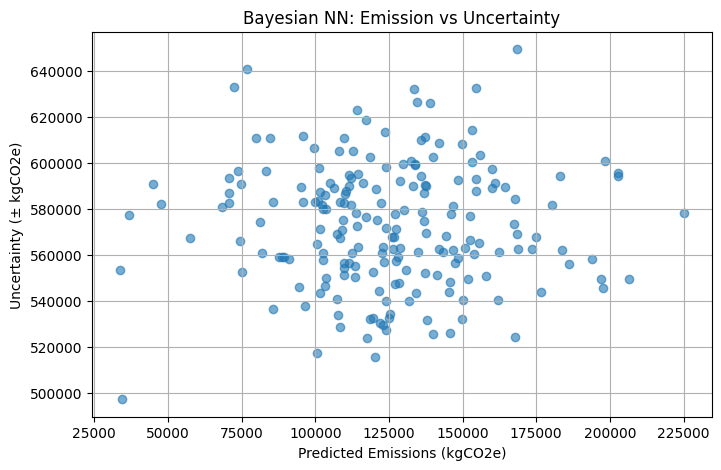

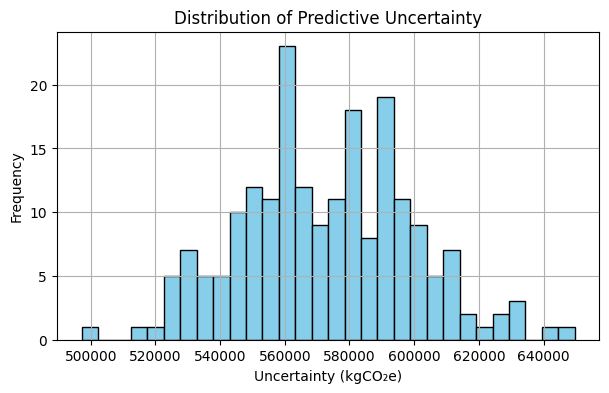

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_mean_orig, y_pred_std_orig, alpha=0.6)
plt.xlabel("Predicted Emissions (kgCO2e)")
plt.ylabel("Uncertainty (± kgCO2e)")
plt.title("Bayesian NN: Emission vs Uncertainty")
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 4))
plt.hist(y_pred_std_orig.flatten(), bins=30, edgecolor='black', color='skyblue')
plt.title("Distribution of Predictive Uncertainty")
plt.xlabel("Uncertainty (kgCO₂e)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

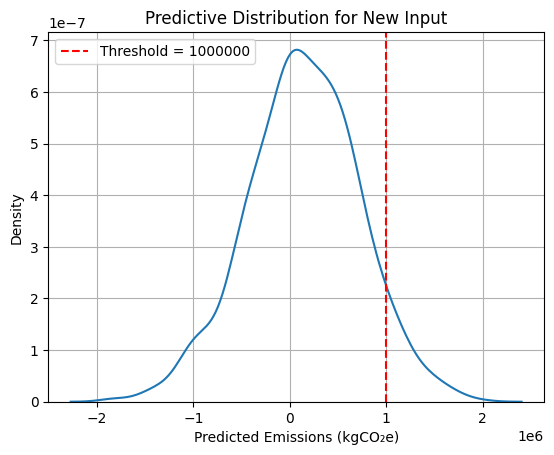

{'mean': 142503.30787933292, 'std': 582423.183959096, 'probability_below_threshold': 0.935}


In [5]:
from bnn_utils import predict_prob_below

new_supplier = df.iloc[[0]].copy()  

# Predict
result = predict_prob_below(
    x_new_df=new_supplier[cat_cols + num_cols],
    threshold=1000000,
    trace=trace,
    preprocessor=preprocessor,
    target_scaler=target_scaler
)

print(result)

This can be interpreted as: "The probability this supplier has emisisons below 1,000,000 is 0.949"

## Final Remarks: Why This Matters for Apple

This notebook demonstrates a complete implementation of a **strict Bayesian Neural Network (BNN)** using PyMC to predict **supplier emissions** with **quantified uncertainty**.

Unlike traditional point-estimate models, this BNN provides:

- **Probabilistic emissions forecasts**  
- **Uncertainty intervals** around each prediction  
- The ability to compute **decision-supportive probabilities**, such as:  
  *“What’s the chance this supplier emits more than 100,000 kgCO₂e?”*

---

## Why This Is Useful for Apple

As Apple targets **carbon neutrality by 2030**, supply chain emissions represent one of the hardest-to-track areas. This notebook offers a framework to:

### 1. Identify High-Risk Suppliers
- Rank suppliers not just by emissions, but by **emissions × uncertainty**
- Prioritise audits where impact and ambiguity are both high

### 2. Make Risk-Aware Decisions
- Instead of hard thresholds, decisions can be made using **probability-weighted logic**
- Example: “If there’s an 80% chance this supplier exceeds our limit, initiate verification”

### 3. Drive Explainability and Transparency
- Visual tools (like uncertainty histograms and predictive distributions)
- Stakeholders can **see and understand** model confidence

### 4. Enable Continuous Refinement
- As more supplier data becomes available, posterior estimates improve
- The model becomes **self-improving and scalable**

---

## Next Steps

- Integrate results into a Streamlit-based **Supplier Risk Portal**
- Expand to **multi-class classification** for emission bands (e.g., low/medium/high)
- Combine with **SBTi targets or auditability compliance frameworks**
- Explore temporal extensions with **Bayesian Time-Series forecasting**